# **Simulazioni MD con il modulo CMS: le classi writer**

---

## Introduzione

Quando si esegue una simulazione di dinamica molecolare, descritte in [4-CrystalDynamics](4-CrystalDynamics.ipynb), si potrebbe desiderare salvare le posizioni intermedie degli atomi, magari per generare un'animazione. La classe `CrystalDynamicsResult` è molto versatile, ma non trattiene certe informazioni, per evitare di aggravare eccessivamente la memoria del computer.\
Il modulo [`io`](../../CMS/MolecularDynamics/io.py) contiene due classi studiate ad hoc per questa evenienza, e la soluzione dipende dalle proprie necessità:
- `AtomTracker`: va fornito come argomento alla creazione di un oggetto `CrystalDynamics`; conserva l'intera traiettoria di un singolo atomo all'interno di un file. È possibile passarne più di uno alla volta, per tracciare più atomi contemporaneamente;
- `XYZwriter`: va fornito come argomento alla creazione di un oggetto `CrystalDynamics`; salva periodicamente le posizioni di tutti gli atomi all'interno di un file. Al termine della simulazione, con gli $N$ file prodotti sarà possibile ricostruite sommariamente la traiettoria dell'intero sistema.

### Tracciamento con e senza pcb

Quando si traccia la posizione di un atomo in una simulazione con `CMS`, si deve scegliere se salvare la posizione così com'è, o se applicare le condizioni periodiche al contorno. 
- l'atomo potrebbe uscire dalla cella del nostro cristallo ma, se le condizioni periodiche al contorno sono state impostate, esso continuerà ad influenzare gli altri atomi sotto forma della sua immagine; 
- nel tracciare la traiettoria, possiamo scegliere se conservare la posizione effettiva dell'atomo, che quindi è libero di uscire dalla struttura cristallina in esame, oppure scambiarlo con la sua immagine ogni volta che attraversa la cella

l'immagine qui riportata sintetizza il problema in questione:

<img src="../images/5-io/periodic-atom-tracker.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: 5px; width: 500px;">

---

## `AtomTracker`

Per costruire un oggetto `AtomTracker` è necessario fornirgli l'indice dell'atomo che vogliamo tracciare, oltre che la posizione e il nome del file in cui vogliamo vengano stampate le informazioni. 

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`index`** | int | / | Indice dell'atomo che si vuole tracciare |
| **`output_file`** | str | /| Posizione e nome del file in cui scrivere le posizioni |
| **`pbc_option`** | str | 'unbounded' | Se tracciare la traiettoria originale dell'atomo o applicare le pbc quando esce dalla cella |

</div>


Supponiamo di voler tracciare la traiettoria di un adatom, aggiunto sulla superficie del cristallo [fcc100a256_1.txt](../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a108_1.txt), impostando le condizioni periodiche al contorno in modo da simulare una _slab_ infinita. Useremo il medoto `CrystalStructure.add_atom()`per posizionare l'atomo da studiare; essendo l'ultimo atomo aggiunto, il suo indice sarà `-1`.

In [1]:
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure
# istanzio il cristallo
nomefile = "../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a256_1.txt"
cristallo = CrystalStructure.from_file(nomefile)
# imposto i raggi di cutoff, giunzione e Verlet
cristallo.set_R_C(4.5)
cristallo.set_R_P(4.2)
cristallo.set_R_V(5.)
# imposto le condizioni periodiche al contorno sugli assi x e y
import numpy as np
condizioni = (16.6416, 16.6416, np.inf)
cristallo.set_pbc(condizioni)
# coordinate del centro del cristallo
x_center, y_center, _ = cristallo.crystal_center
# posiziono l'adatom al centro, 2 A sopra la superficie
z_max = np.max(cristallo.vec_z)
posizione_adatom = (x_center, y_center, z_max + 2)
cristallo.add_atom(posizione_adatom)

Andremo a tracciare la traiettoria con entrambe le opzioni `unbounded` e `periodic` per studiarne la differenza.

In [2]:
from CMS.MolecularDynamics.io import AtomTracker
# istanzio l'AtomTracker con opzione periodica
periodic_adatom_tracker= AtomTracker(
    index=-1,
    output_file="../tutorials_outputs/periodic-AtomTracker-tutorial.txt",
    pbc_option='periodic' # traiettoria periodica
)
# istanzio l'AtomTracker con opzione libera
unbounded_adatom_tracker= AtomTracker(
    index=-1,
    output_file="../tutorials_outputs/unbounded-AtomTracker-tutorial.txt",
    pbc_option='unbounded' # traiettoria libera
)

Gli `AtomTracker` appena instanziati possono essere passati in coppia al momento della costruzione di un oggetto `CrystalDynamics`.

In [3]:
# scelgo i parametri di simulazione
atomic_mass = 108
time_step = 1.E-15
temp_ini  = 2000 # T_fin ~ 1000 K 

from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics
# istanzio l'algoritmo
dinamica = CrystalDynamics(
    crystal=cristallo.copy(),
    atomic_mass=atomic_mass,
    dt=time_step,
    temp_ini=temp_ini,
    atom_tracker=(unbounded_adatom_tracker, periodic_adatom_tracker)
)
# scelgo un seed arbitrario per la simulazione
dinamica.set_seed(13543)

Quindi lanciamo la simulazione con una durata di 100ps:

In [4]:
tempo_totale = 100E-12 # 100 ps
n_steps = int(tempo_totale / time_step) # calcolo il numero di step necessari
tempo_termalizzazione = 3E-12 # 3 ps

# lancio la simulazione
result = dinamica.run_dynamics(
    n_steps=n_steps,
    t_th=tempo_termalizzazione
)

### Esempio di analisi

Ora che le traiettorie sono salvate nei file [unbounded-AtomTracker-tutorial.txt](../tutorials_outputs/unbounded-AtomTracker-tutorial.txt) e [periodic-AtomTracker-tutorial.txt](../tutorials_outputs/periodic-AtomTracker-tutorial.txt), possono essere estratte e visualizzate per confrontare le due opzioni.

In [5]:
# estrazione dei dati
periodic_adatom_data = np.loadtxt("../tutorials_outputs/periodic-AtomTracker-tutorial.txt", skiprows=2, delimiter="\t")
x1 = periodic_adatom_data[:, 1]
y1 = periodic_adatom_data[:, 2]

unbounded_adatom_data = np.loadtxt("../tutorials_outputs/unbounded-AtomTracker-tutorial.txt", skiprows=2, delimiter="\t")
x2 = unbounded_adatom_data[:, 1]
y2 = unbounded_adatom_data[:, 2]

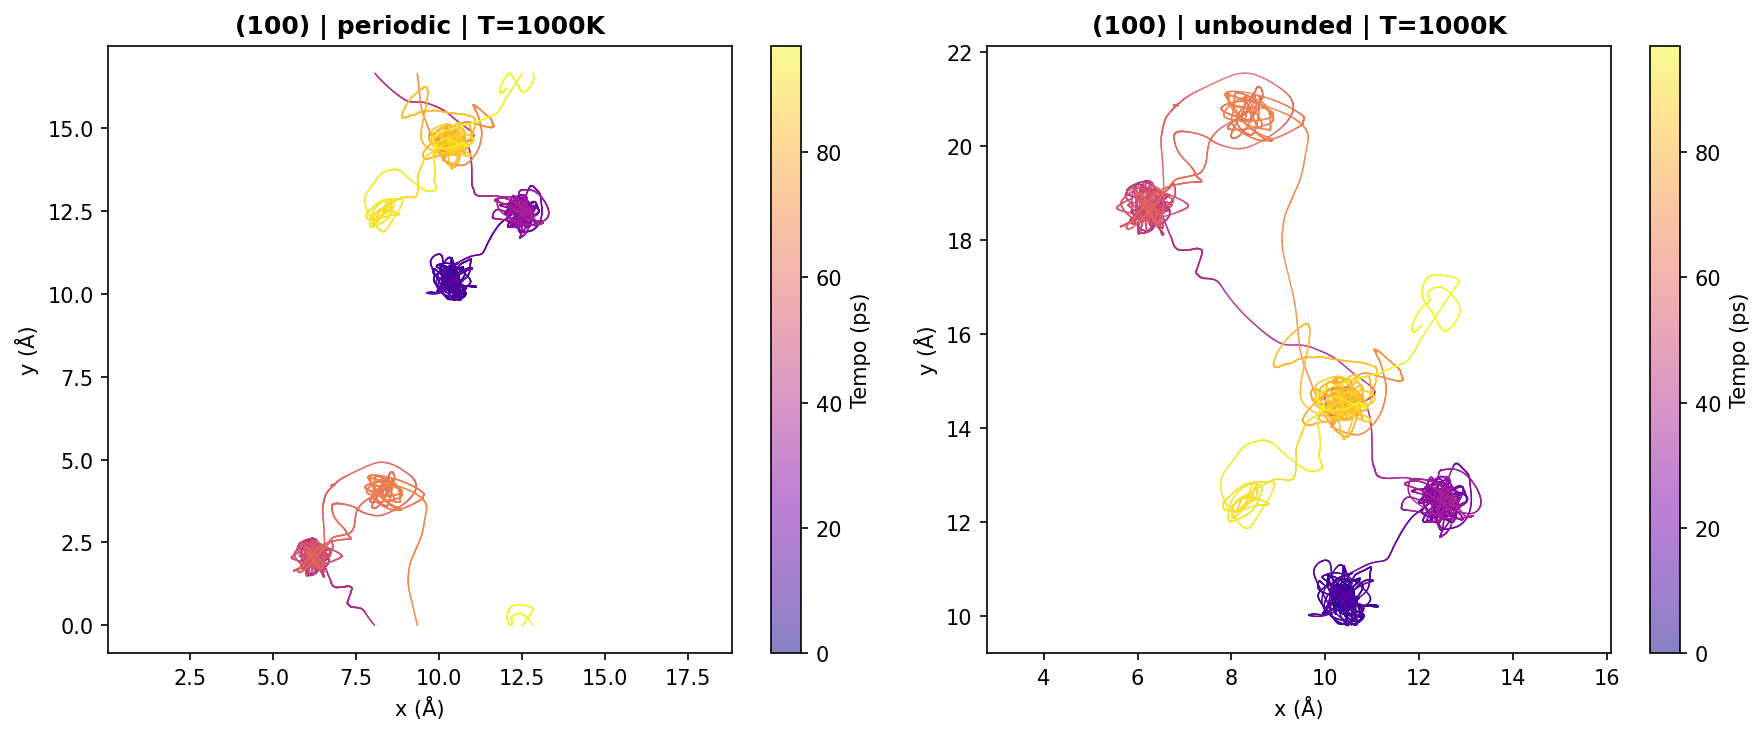

In [6]:
import matplotlib.pyplot as plt
# metto due grafici uno accanto all'altro 
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Creiamo un array di indici per il colore
time_indices1 = np.arange(len(x1)) * (time_step * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter
ax[0].scatter(x1, y1, c=time_indices1, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[0].set_xlabel('x (Å)')
ax[0].set_ylabel('y (Å)')
ax[0].set_title("(100) | periodic | T=1000K", fontweight='bold')
ax[0].axis('equal') # Per non distorcere la geometria

cbar1 = plt.colorbar(ax[0].collections[0], ax=ax[0])
cbar1.set_label('Tempo (ps)')

# Creiamo un array di indici per il colore
time_indices2 = np.arange(len(x2)) * (time_step * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter. 
# c=time_indices dice di usare l'indice per il colore
# s=0.5 rende i punti piccolissimi
# linewidth=0 toglie il bordo ai punti per evitare che si sovrappongano troppo
ax[1].scatter(x2, y2, c=time_indices2, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[1].set_xlabel('x (Å)')
ax[1].set_ylabel('y (Å)')
ax[1].set_title("(100) | unbounded | T=1000K", fontweight='bold')
ax[1].axis('equal') # Per non distorcere la geometria

cbar2 = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar2.set_label('Tempo (ps)')

plt.tight_layout()
plt.show()

> 🔍  Da questi grafici, rappresentanti quasi 100mila step a temperatura elevata, è subito evidente un fatto: l'_adatom_ passa la maggior parte del tempo **vibrando** attorno a una posizione di **equilibrio**, spostandosi in un altro sito solo occasionalmente. In tutto 7 posizioni sono state occupate, quindi soltanto 6 eventi di diffusione. Per lo studio dei processi di superficie, esistono tecniche che si concentrano solamente sugli eventi più rilevanti, come la [KineticMonetCarlo](../MonteCarlo/KineticMonteCarlo.ipynb).

---

## `XYZwriter`

Per costruire un oggetto `XYZwriter` è necessario la posizione e il nome della cartella in cui vogliamo vengano raccolte le informazioni. Ogni `n=dump_interval` steps verrà creato un file .xyz con le coordinate di tutti gli atomi.

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`output_folder`** | int | / | Posizione e nome della **cartella* in cui creare i file di coordinate |
| **`dt`** | str | /| Passo temporale della simulazione |
| **`dump_interval`** | str | 200 | Ogni quanti step creare un file di coordinate |
| **`pbc_option`** | str | 'unbounded' | Se tracciare la traiettoria originale dell'atomo o applicare le pbc quando esce dalla cella |

</div>


output_folder: str,
    dt: float,
    dump_interval: int = 200,
    pbc_option

In [7]:
from CMS.MolecularDynamics.io import XYZwriter

writer = XYZwriter(
    output_folder="../tutorials_outputs/unbounded-XYZwriter-tutorial/",
    dt=time_step,
    dump_interval=300, # prevediamo 50_000 steps, se salvo ogni 300 step ottengo 167 frame
    pbc_option='unbounded'
)

Quindi eseguiamo una simulazione identica alla precedente:

In [8]:
# istanzio nuovamente l'algoritmo, questa volta con l'XYZwriter
dinamica = CrystalDynamics(
    crystal=cristallo.copy(),
    atomic_mass=atomic_mass,
    dt=time_step,
    temp_ini=temp_ini,
    atom_tracker=None,
    xyz_writer=writer
)
# scelgo un seed arbitrario per la simulazione
dinamica.set_seed(13543)

# lancio la simulazione
result = dinamica.run_dynamics(
    n_steps=n_steps,
    t_th=tempo_termalizzazione
)

Se ora andiamo a visualizzare la sequenza di file generati in [tutorials_outputs/unbounded-XYZwriter-tutorial](../tutorials_outputs/unbounded-XYZwriter-tutorial) con un software come Ovito, vedremo qualcosa di questo genere:

<img src="../images/5-io/unbounded-writer-tutorial.gif" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: auto; width: 400px;">